# _Short Long Portfolio_

The following notebook will introduce you to a simple performance analyses of our long only strategy for a timeline of 105 months between 2011 and 2019. Our benchmark is the EONIA +4% (per year) and fees are applied annually.

How to spread 4% per year into monthly returns ? We assume that +4% per year = to 0.327% per month ($x^{12}= 1.04 \iff x= 0.00327$). Then, we add this constant float to EONIA monthly rates.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from texttable import Texttable
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy
from scipy.stats import skewnorm

In [2]:
data= pd.read_csv("../data/long_short_return_.csv")
data['date'] = pd.to_datetime(data['date'])
data['eonia_4'] = (data['eonia'].str.replace(',','.').astype(float)/100)+ 0.00327
data['effectif'] = data['effectif']/100
data['pred'] = data['pred']/100
data.head()

,date,effectif,pred,eonia,eonia_4
0,2011-03-01,0.101529,0.091594,"0,659",0.00986
1,2011-04-01,0.051643,0.149672,"0,966",0.01293
2,2011-05-01,0.038508,0.132326,"1,033",0.01360
3,2011-06-01,-0.013343,0.131231,"1,124",0.01451
4,2011-07-01,-0.092120,0.106597,"1,012",0.01339


### A). Quick statistics

In [3]:
t = Texttable()
t.add_rows([['Series', 'Mean Return', 'Std', 'Kurtosis', 'Skewness'], 
            ['EONIA + 4%', str(round(data['eonia_4'].mean()*100,2))+'%', str(round(data['eonia_4'].std()*100,2))+'%',
             str(round(kurtosis(data['eonia_4']),2))+'%',  str(round(skew(data['eonia_4']),2))+'%'], 
            
            ['Portfolio', str(round(data['effectif'].mean()*100,2))+'%', str(round(data['effectif'].std()*100,2))+'%',
              str(round(kurtosis(data['effectif']),2))+'%',  str(round(skew(data['effectif']),2))+'%'
            ]])

print(t.draw())
ex_ret = (round((data['effectif'].mean()*100-data['eonia_4'].mean()*100),3)) 
print('The Excess Return of our Portfolio on average is: '+str(ex_ret)+'% compared to our benchmark')

+------------+-------------+-------+----------+----------+
|   Series   | Mean Return |  Std  | Kurtosis | Skewness |
+============+=============+=======+==========+==========+
| EONIA + 4% | 0.29%       | 0.39% | 1.24%    | 1.33%    |
+------------+-------------+-------+----------+----------+
| Portfolio  | 0.26%       | 4.42% | 1.81%    | -0.3%    |
+------------+-------------+-------+----------+----------+
The Excess Return of our Portfolio on average is: -0.034% compared to our benchmark



- The chart shows the difference in volatility of our two series, clearly our portfolio is more volatile. 
- Correlation between our series: -9.4%


C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


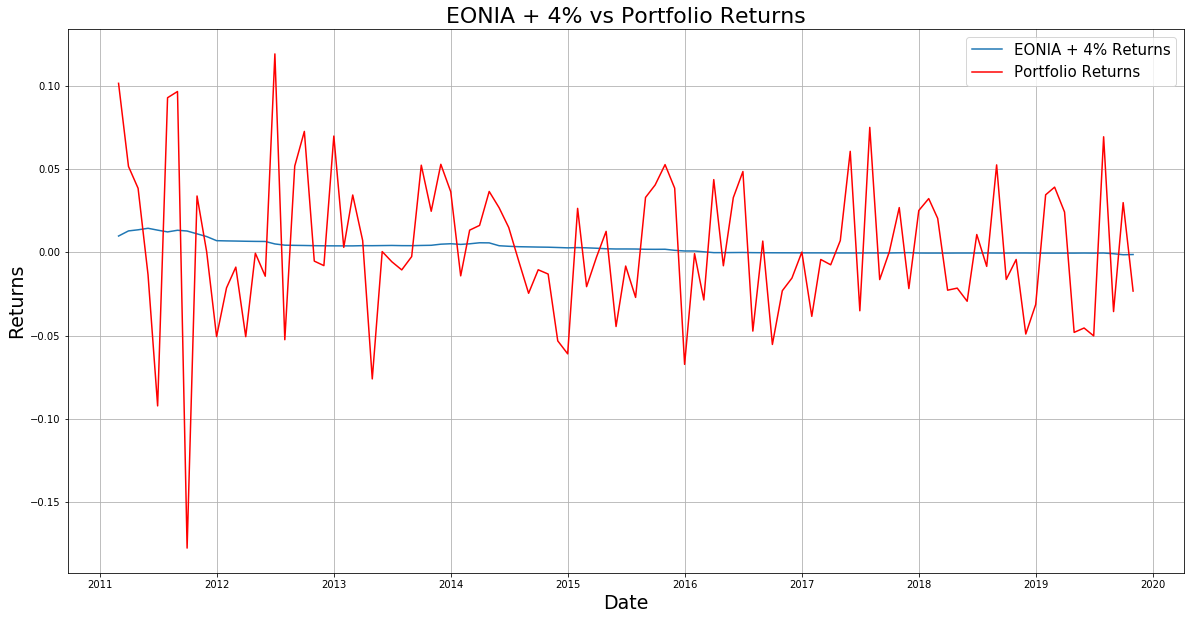

In [4]:
plt.figure(figsize=(20,10))
plt.plot(data.date, data.eonia_4, label='EONIA + 4% Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

plt.title('EONIA + 4% vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly our portfolio is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()


- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile. 
- Correlation between our series: -9.4%


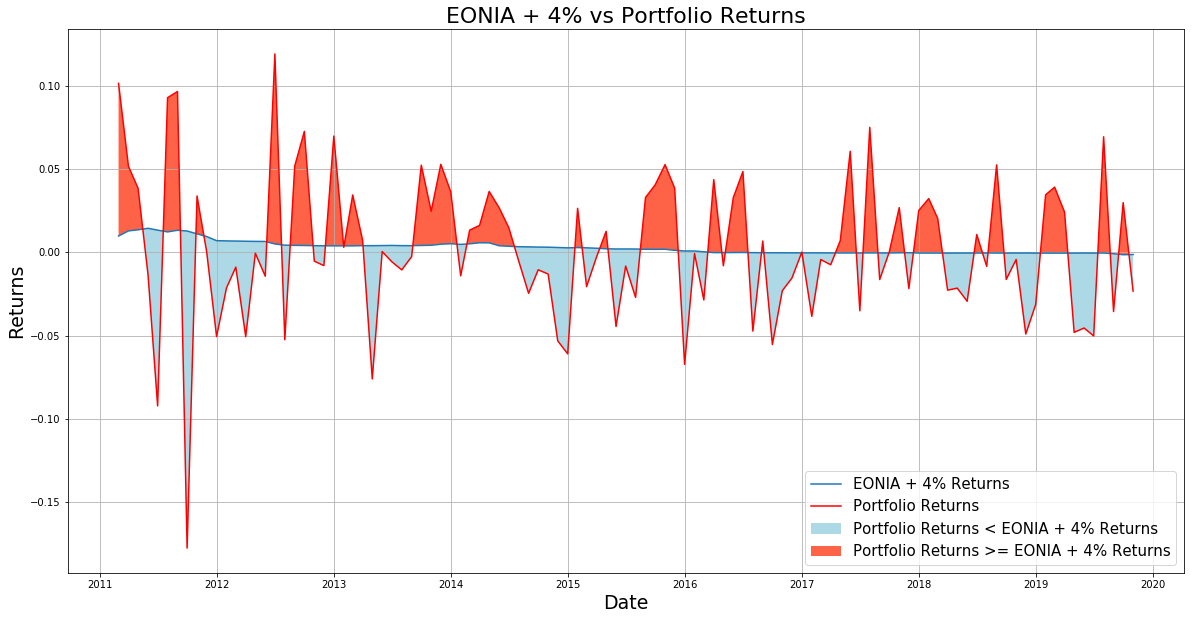

In [5]:
plt.figure(figsize=(20,10))
plt.plot(data.date, data.eonia_4, label='EONIA + 4% Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

# If our portfolio return is above EONIA + 4%, then color the area between SP and portfolio return in tomato
# else fill with lightblue
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] > data["effectif"]
                , facecolor= "lightblue"
                , interpolate= True
                , label= "Portfolio Returns < EONIA + 4% Returns")
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] <= data["effectif"]
                , facecolor= "tomato"
                , interpolate= True
                , label= "Portfolio Returns >= EONIA + 4% Returns")


plt.title('EONIA + 4% vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()

COMMENTAIRES

### B). Notes about normality distribution, random walk and extreme returns

In [6]:
# Normality distribution of our returns

def compare_hist_to_norm(data, bins= 25):
    fig= plt.figure(figsize= (10, 5))
    # mu, std, sk, k= scipy.stats.norm.stats(data, moments='mvsk')
    mu, std= scipy.stats.norm.fit(data)
    # params= scipy.stats.norm.fit(data)
    # sk= scipy.stats.skewnorm(data)
    # Plot l'hist
    plt.hist(data, bins= bins, density=True, alpha=0.6,
    color='purple', label= "Données")
    # Plot le PDF.
    
    xmin, xmax= plt.xlim()
    X= np.linspace(xmin, xmax)
    
    plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label= "Normal Distribution")
    plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color= 'black', label= "Skewed Normal Distribution")
    
    mu, std= scipy.stats.norm.fit(data)
    sk= scipy.stats.skew(data)
    
    title2= "Moments mu: {}, sig: {}, sk: {}".format(round(mu,4), round(std, 4), round(sk, 4))
    plt.ylabel("Fréquence", rotation= 90)
    plt.title(title2)
    plt.legend()
    
    plt.show()

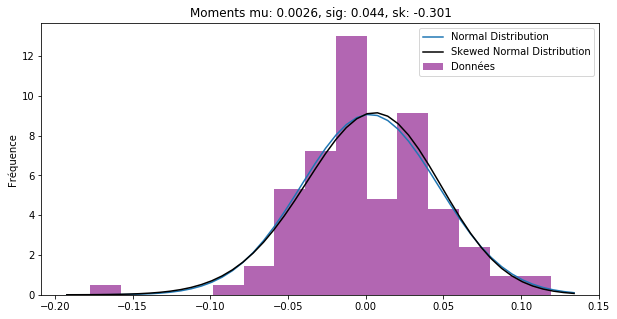

In [7]:
# Our portfolio returns
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["effectif"].values], bins= 15)

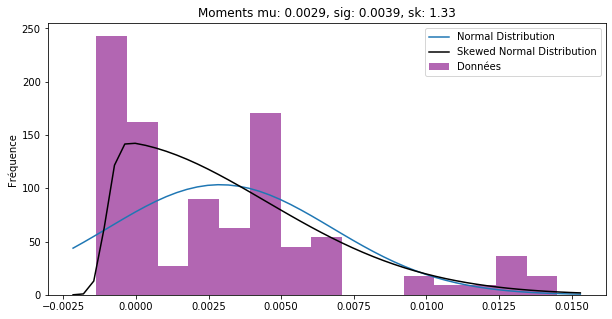

In [8]:
# SPX distribution
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["eonia_4"].values], bins= 15)

<Figure size 720x504 with 0 Axes>

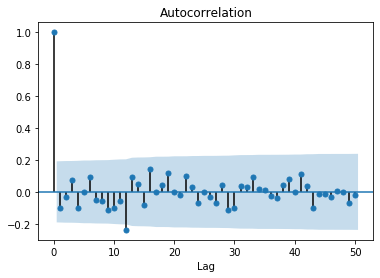

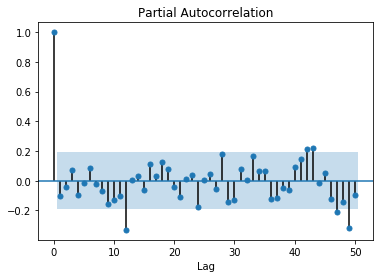

In [9]:
# Autocorrelation for all periods (with confidence intervals)

plt.figure(figsize=(10,7))

plot_acf(data["effectif"], lags= 50)
plt.xlabel("Lag")
# partial autocorr
plot_pacf(data["effectif"], lags= 50)
plt.xlabel("Lag")

plt.show()

COMMENTAIRES

### C). Rolling metrics

In [10]:
# Rolling metrics
window= 36
lag= 1 # for autocorrelation

effectif_rolling_mean= data["effectif"].rolling(window).mean()
effectif_rolling_mean.index= data["date"]
effectif_rolling_std= data["effectif"].rolling(window).std()
effectif_rolling_std.index= data["date"]
effectif_rolling_autocorr= data["effectif"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
effectif_rolling_autocorr.index= data["date"]


sp_rolling_mean= data["eonia_4"].rolling(window).mean()
sp_rolling_mean.index= data["date"]
sp_rolling_std= data["eonia_4"].rolling(window).std()
sp_rolling_std.index= data["date"]
sp_rolling_autocorr= data["eonia_4"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
sp_rolling_autocorr.index= data["date"]

C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


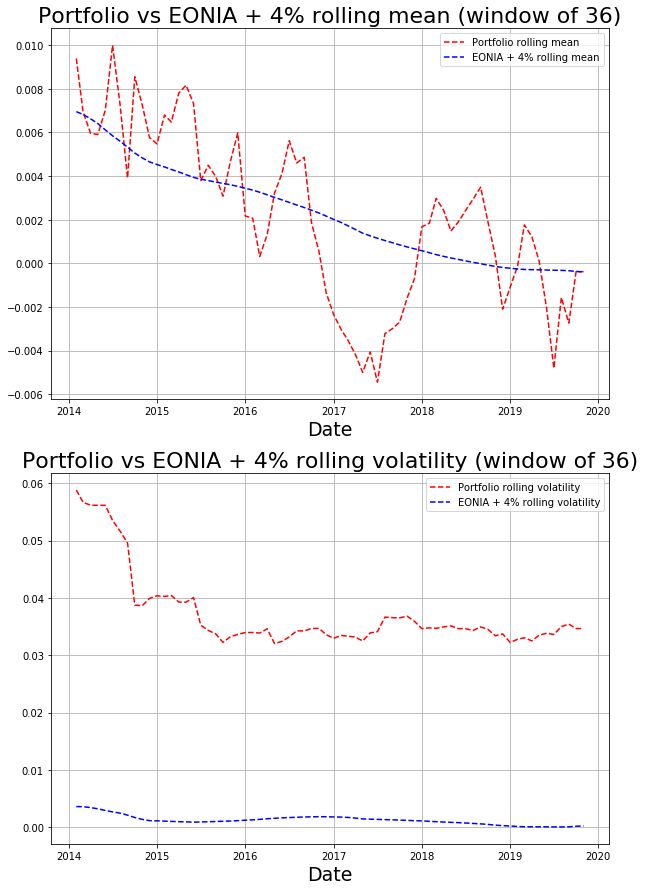

In [11]:
# PLot rolling metrics

# fig= plt.figure(figsize= (20, 30))
ligne= 2
fig, ax= plt.subplots(ligne, 1, figsize= (10, 15))

legend_dico= {0: "mean", 1: "volatility"}
def return_title(i, dic= legend_dico, window= window):
    return "Portfolio vs EONIA + 4% rolling {} (window of {})".format(dic[i], window)

# Rolling mean
mean= return_title(0)
ax[0].plot(effectif_rolling_mean, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[0]))
ax[0].plot(sp_rolling_mean, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[0]))
ax[0].set_title(mean, size= 22)

# Rolling std
std= return_title(1)
ax[1].plot(effectif_rolling_std, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[1]))
ax[1].plot(sp_rolling_std, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[1]))
ax[1].set_title(std, size= 22)

for i in range(ligne):
    ax[i].set_xlabel("Date", fontsize= 19)
    ax[i].grid()
    ax[i].legend()

plt.show()

COMMENTAIRES

### D). Portfolio evaluation

#### 1).

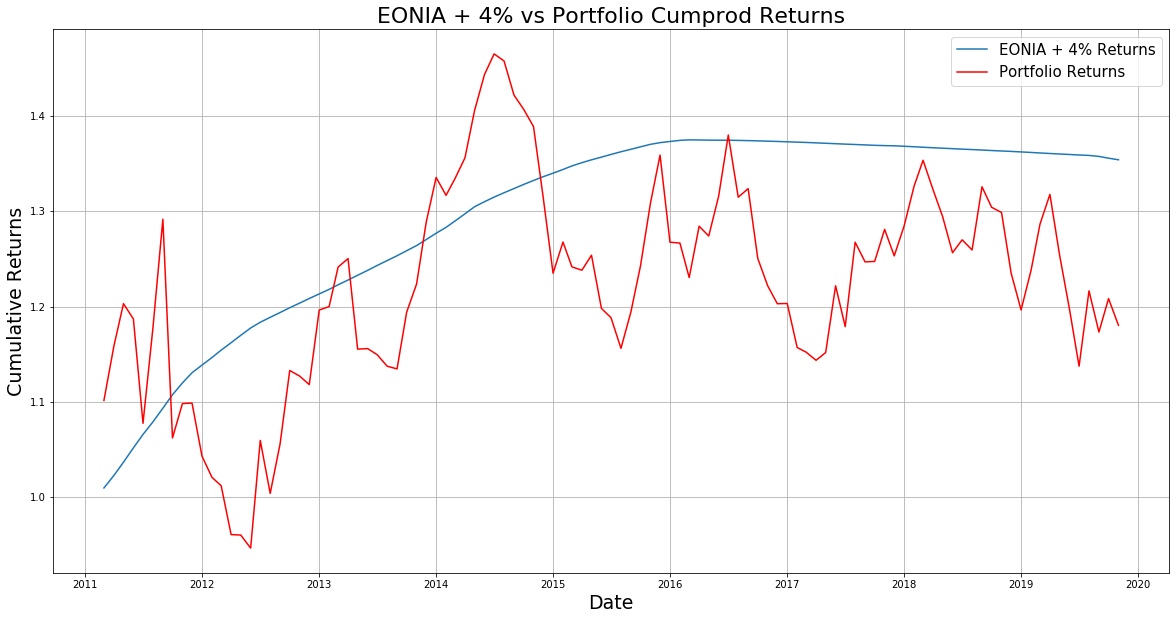

In [12]:
plt.figure(figsize=(20,10))
plt.plot(data.date,(1+data['eonia_4']).cumprod(),label='EONIA + 4% Returns')
plt.plot(data.date,(1+data['effectif']).cumprod(), c='r', label='Portfolio Returns')
plt.title('EONIA + 4% vs Portfolio Cumprod Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Cumulative Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

In [13]:
#################### FEES #######################################
df = data.copy()

fees = (1.01)**(1/12) - 1

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['withfees'] = df['effectif'] - fees

# We create a two lists to iterate for creating slices of dataframe 

a = [0] + (list(df[df['month'] == 12].index)) 
b =  (list(df[df['month'] == 12].index)) + [104]

# The length of the two should match

len(a) == len(b)

True

In [14]:
# List that will keep the final values
portfolio_final = []

for l1,l2 in zip(a,b):
    
    # This "if" catches the year that we had only 10 months
    if l2 - l1 < 11:
        # It slices the dataframes and it takes the the cumprud of those current slices
        slice_df =  df.iloc[ l1: l2+1]
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        # Bonus 
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(10)) - 1
#         print(bonus)
        if pptcpr[-1] > spxcpr[-1]:
#             pptcpr = pptcpr - bonus
            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)     
        
    # This "if" catches the years that are full 12 months
    elif l2 - l1 == 12:
        
        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(12)) - 1

        if pptcpr[-1] > spxcpr[-1]:
#             pptcpr = pptcpr - bonus
            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)
        
    # This "if" catches the years that we had 11 months
    elif l2 - l1 == 11 : 

        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()

        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(11)) - 1
        
        if pptcpr[-1] > spxcpr[-1]:
#             pptcpr = pptcpr - bonus
            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees) 

df['final_ppt'] = np.concatenate(portfolio_final, axis=0)

data2= df.copy()
data2.head()

,date,effectif,pred,eonia,eonia_4,month,withfees,final_ppt
0,2011-03-01,0.101529,0.091594,"0,659",0.00986,3,0.100700,0.100700
1,2011-04-01,0.051643,0.149672,"0,966",0.01293,4,0.050813,0.050813
2,2011-05-01,0.038508,0.132326,"1,033",0.01360,5,0.037678,0.037678
3,2011-06-01,-0.013343,0.131231,"1,124",0.01451,6,-0.014172,-0.014172
4,2011-07-01,-0.092120,0.106597,"1,012",0.01339,7,-0.092949,-0.092949


In [15]:
t = Texttable()
t.add_rows([['Series', 'Total Return'], 
            ['EONIA + 4%', str(round(list((1+data['eonia_4']).cumprod())[-1]-1,3)*100)+'%'] ,
            
            ['Portfolio (without fees)',  str(round(list((1+data['effectif']).cumprod())[-1]-1,3)*100)+'%'
            ],
            
            ['Portfolio (with fees)',  str(round(list((1+data2['final_ppt']).cumprod())[-1]-1,2)*100)+'%'
            ]
           ])
print(' Results in Cumulative Return (without fees)')
print(t.draw())

 Results in Cumulative Return (without fees)
+--------------------------+--------------+
|          Series          | Total Return |
+==========================+==============+
| EONIA + 4%               | 35.4%        |
+--------------------------+--------------+
| Portfolio (without fees) | 18.0%        |
+--------------------------+--------------+
| Portfolio (with fees)    | 6.0%         |
+--------------------------+--------------+


In [16]:
def alpha_beta(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
#     x = x.values
#     y = y.values
    
    # Adding constant
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    if verbose == True:
        t = Texttable()
        t.add_rows([['Series', 'Alpha' , 'Beta'], 
            ['EONIA + 4%', str(round(alpha,2))+' %',str(round(beta,2))+' %']])
        print(t.draw())
    else:
        return alpha, beta
    
print('The results are shown for the entire period (wihtout fees)')
alpha_beta(data["eonia_4"].values, data["effectif"].values)

# on recalcul les beta / alpha avec les ct !
# en global
print('\nThe results are shown for the entire period (with fees)')
alpha_beta(data2["eonia_4"].values, data2["final_ppt"].values)

The results are shown for the entire period (wihtout fees)
+------------+-------+--------+
|   Series   | Alpha |  Beta  |
+============+=======+========+
| EONIA + 4% | 0.0 % | 0.83 % |
+------------+-------+--------+

The results are shown for the entire period (with fees)
+------------+--------+--------+
|   Series   | Alpha  |  Beta  |
+============+========+========+
| EONIA + 4% | -0.0 % | 0.83 % |
+------------+--------+--------+


COMMENTAIRES

#### 2).

In [17]:
# This function will create windows 
def windows(iterable, n, m=1):
    length = len(iterable)
    i = 0

    while i + n < length:
        yield list(iterable[i:i + n+1])
        i += m

In [18]:
roll_alpha = []
roll_beta = []
n = 36

for be, al in zip((windows(data["eonia_4"], 36, 1)),(windows(data["effectif"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)

roll_alpha_before= roll_alpha
roll_beta_before= roll_beta

roll_alpha = []
roll_beta = []

for be, al in zip((windows(data2["eonia_4"], 36, 1)),(windows(data2["final_ppt"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)


- The chart shows the rolling Alpha with a window of 36


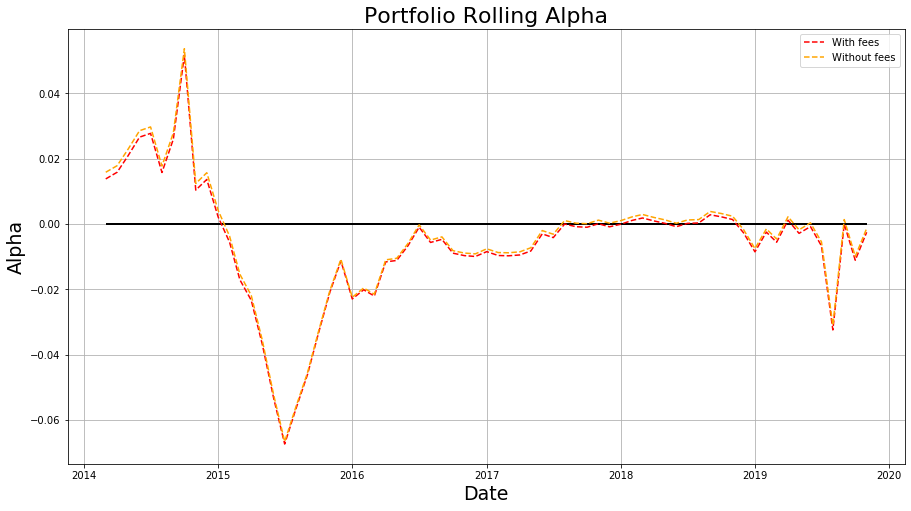

In [19]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_alpha):]
         , roll_alpha, label="With fees"
         , color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_alpha_before):]
         , roll_alpha_before, label='Without fees'
         , color= "orange", linestyle= "--")

plt.hlines(np.repeat(0, len(roll_alpha))
           , xmin= data2.date.values[-len(roll_alpha_before):][0]
           , xmax= data2.date.values[-len(roll_alpha_before):][-1]
           , color= "black"
          )

plt.title('Portfolio Rolling Alpha', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Alpha', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Alpha with a window of 36')
plt.show()


- The chart shows the rolling Beta with a window of 36


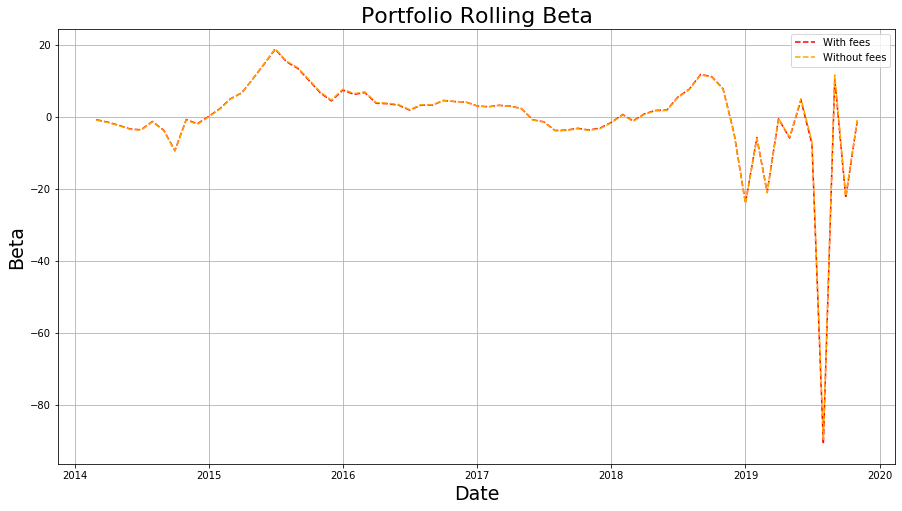

In [20]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_beta):]
         , roll_beta, label='With fees', color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_beta_before):]
         , roll_beta_before, label='Without fees', color= "orange", linestyle= "--")

# plt.vlines(ymin= 0.3, ymax= 0.9, x= "2018")

plt.title('Portfolio Rolling Beta', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Beta', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Beta with a window of 36')
plt.show()

COMMENTAIRES

#### 3).

COMMENTAIRES